In [6]:
# Import packages:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

# Set default plotting parameters:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams[ 'font.sans-serif'  ] = 'Calibri'
mpl.rcParams[ 'font.size'        ] = 10
mpl.rcParams[ 'mathtext.default' ] = 'regular'          
mpl.rcParams[ 'xtick.direction'  ] = 'out'
mpl.rcParams[ 'ytick.direction'  ] = 'out'       
mpl.rcParams[ 'lines.linewidth'  ] = 1.0     

dt = 1./24. # define sampling frequency in days

# Specify dataset name:
name = str(int(np.loadtxt('Data/name.txt')))

# Import datasets created by titree2.py script:
tide  = np.loadtxt('Data/tide.dat', dtype=str)
p     = np.loadtxt('Data/p.dat') 
NP    = len(p)
omega = np.loadtxt('Data/omega.dat')
t1 = np.loadtxt('Data/t1.dat')
w1 = np.loadtxt('Data/w1.dat')         
T1 = np.loadtxt('Data/t1b.dat')          
t2 = np.loadtxt('Data/t2.dat')  
T2 = np.loadtxt('Data/t2b.dat')  
h2 = np.loadtxt('Data/h2.dat')  
w2 = np.loadtxt('Data/w2.dat')  
bp = np.loadtxt('Data/bp.dat')  
t  = np.loadtxt('Data/t.dat')  
x  = np.loadtxt('Data/x.vec')  
y  = np.loadtxt('Data/y.vec')  
dx = np.loadtxt('Data/dx.dat')  
dy = np.loadtxt('Data/dy.dat')  

n   = len(dx)
nn  = np.loadtxt('Data/nn.dat')   
lag = np.loadtxt('Data/lag.dat')  
nm  = len(lag)
v   = np.loadtxt('Data/v.mat')  

X = np.loadtxt('Data/X.mat')  
Z = np.loadtxt('Data/Z.mat')  

c  = np.loadtxt('Data/c.dat')  
nc = len(c)

# Resample vented groundwater pressure data to hourly frequency:
ta = np.arange(t1[0], t1[-1]+dt, dt)
n = len(ta)
ya = np.interp(ta, t1, w1) 

# Re-formulate u1 and u2 sub-matrices: (?)
u1 = np.zeros([n, NP])
u2 = u1.copy()
for i in range(NP):
    u1[:,i] = np.cos(omega[i]*ta)
    u2[:,i] = np.sin(omega[i]*ta)

# Re-formulate Z matrix: (?)
Za = np.hstack([np.atleast_2d(np.ones(len(ta))).T, 
                np.atleast_2d(ta).T, 
                u1, u2])  

# Re-calculate c vector by solving the linear system of equations Z*dy=c: 
ca = np.linalg.lstsq(Za, ya, rcond=None)[0]
nc = len(ca)
np.savetxt('Data/ca.dat', ca)

# Re-calculate observation and parameter standard errors: (?)
pya = ya-np.dot(np.hstack([u1, u2]), ca[2:nc])
oerror = np.std(ya-ca[1]*ta)
perror = np.std(np.atleast_2d(ya).T - np.dot(Za, np.atleast_2d(ca).T))

trend = ca[1] # re-calculate trend term
k = 1+np.arange(NP)
trf = [a+1j*b for a,b in zip(ca[k], ca[NP+k])] # re-calculate complex barometric response function
mag = np.abs(trf) # re-calculate amplitude values of trf
phase = np.angle(trf) # re-calculate phase values of trf 

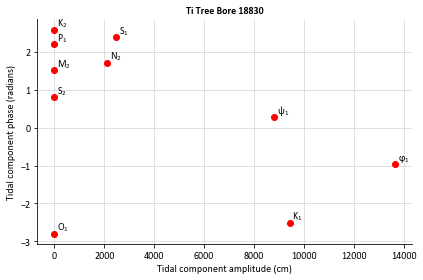

In [7]:
# Re-plot Nyquist plot (i.e. amplitude versus phase) of values derived from complex barometric response function:  
%matplotlib inline
f,s = plt.subplots()
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
s.plot(mag, phase, 'ro')
s.set_xlabel('Tidal component amplitude (cm)')
s.set_ylabel('Tidal component phase (radians)')
#s.set_xlim(0., 14000.)
#s.set_ylim(-3., 3)
for i in range(NP):
    s.text(mag[i]+1e2, phase[i]+1e-1, tide[i])
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()

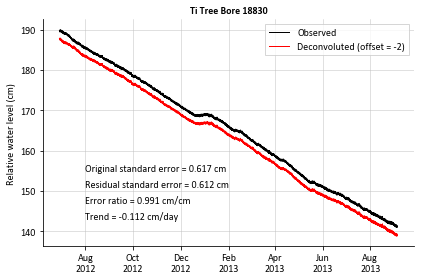

In [8]:
# Convert time data from float values to datetime values:
t  = [datetime.utcfromtimestamp(i) for i in (t -25569.)*86400.]
ta = [datetime.utcfromtimestamp(i) for i in (ta-25569.)*86400.]

# Re-plot observed and deconvoluted pressure values versus time: 
%matplotlib inline
f,s = plt.subplots()
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
s.plot(ta, ya,     'k-', label='Observed')
s.plot(ta, pya-2 , 'r-', label='Deconvoluted (offset = -2)')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
s.set_ylabel('Relative water level (cm)')
s.legend(fancybox=False)
to = datetime(2012, 8, 1)
yo = 155.
s.text(to, yo,     'Original standard error = '+str('%.3f'% oerror)+' cm')
s.text(to, yo-4., 'Residual standard error = '+str('%.3f'% perror)+' cm')
s.text(to, yo-8., 'Error ratio = '+str('%.3f'% (perror/oerror))+' cm/cm')
s.text(to, yo-12., 'Trend = '+str('%.3f'% trend)+' cm/day')
#s.set_xlim(datetime(2012, 6, 15), datetime(2013, 9, 10))
#s.set_ylim(130., 190.)
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()

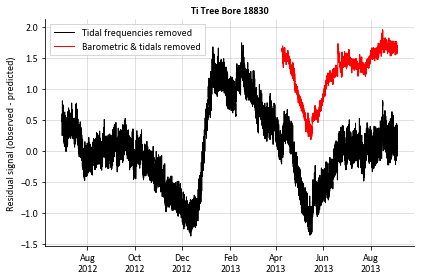

In [9]:
# Plot residuals of detrended vented groundwater pressure data: (?)
%matplotlib inline
f,s = plt.subplots()
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
s.plot(ta, np.atleast_2d(ya).T - np.dot(Za, np.atleast_2d(ca).T), 'k-', label='Tidal frequencies removed')
s.plot(t, y-dt*np.concatenate([[0.], np.cumsum(np.dot(Z, c))])-156., 'r-', label='Barometric & tidals removed')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
s.set_ylabel('Residual signal (observed - predicted)')
#s.set_xlim(datetime(2012, 6, 15), datetime(2013, 9, 10))
#s.set_ylim(-1.5, 2.0)
s.legend(fancybox=False)
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()